In [1]:
%matplotlib widget

isdark = False

from rayoptics.environment import *

In [2]:
opm = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']

osp['pupil'] = PupilSpec(osp, key=['object', 'pupil'], value=16)
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=0.5, flds=[0., 0.707, 1.], is_relative=True)
osp['wvls'] = WvlSpec([('F', 0.5), (587.5618, 1.0), ('C', 0.5)], ref_wl=1)

opm.radius_mode = True

sm.gaps[0].thi=1e10

def calc_curvature(n, fl):
    return (n-1)*fl

n_bk7 = 1.5168
n_lasf9 = 1.85025
n_f2 =  1.62005

v_bk7 = 64.17
v_lasf9 = 32.16
v_f2 = 36.43
# try for chaining a 3x telescope setup with a second 3x telescope setup
f0 = 150
f0_0 = (v_bk7-v_f2)*f0/v_bk7
f0_1 = -f0_0*v_bk7/v_f2
f0_actual = 1/(1/f0_0+1/f0_1)
f1 = 40
# 1/f = 1/f0 + 1/f1 = 1/f0 - v2/(f0*v1) = (v1-v2)/(v1*f0)
# f0 = (v1-v2)*f/v1
f1_0 = (v_bk7-v_f2)*f1/v_bk7
f1_1 = -f1_0*v_bk7/v_f2
print(f0_actual, f1_0, f1_1)
f2 = 150
f3 = 50

f1_stacked = 2*f1

r0 = calc_curvature(n_lasf9, f0)
r0_0 = calc_curvature(n_bk7, f0_0)
r0_1 = calc_curvature(n_f2, f0_1)
r1 = calc_curvature(n_lasf9, f1)
r1_0 = calc_curvature(n_bk7, f1_0)
r1_1 = calc_curvature(n_f2, f1_1)
r2 = calc_curvature(n_lasf9, f2)
r3 = calc_curvature(n_lasf9, f3)

sm.add_surface([r0_0, 2, 'N-BK7', 'Schott', 42/2])
sm.add_surface([1e9, 2, 'N-F2', 'Schott', 42/2])
#sm.add_surface([-r0_1, 180+2*f1])
sm.add_surface([-r0_1, 180+2*36.])

#sm.add_surface([r1_0, 6, 'N-BK7', 'Schott', 16])
#sm.add_surface([1e9, 2, 'N-F2', 'Schott', 16])
#sm.add_surface([-r1_1, 30])
#sm.add_surface([1e9, 2, 'N-LASF9', 'Schott', 16])
#sm.add_surface([-r1, f2+f3])

#sm.add_surface([r2, 2, 'N-LASF9', 'Schott', 16])
#sm.add_surface([1e9, f2+f3])
#sm.add_surface([1e9, 2, 'N-LASF9', 'Schott', 16])
#sm.add_surface([-r3, f3])


150.0 17.29156926912888 -30.45841339555312


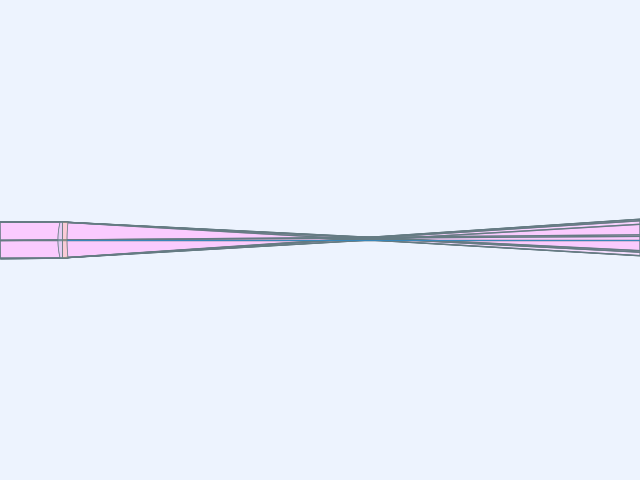

In [3]:
opm.update_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()

In [4]:
pm.first_order_data()

efl               142.6
ffl              -145.8
pp1              -3.188
bfl                 137
ppk               5.616
f/#               8.914
m            -1.426e-08
red          -7.011e+07
obj_dist          1e+10
obj_ang             0.5
enp_dist             -0
enp_radius            8
na obj            8e-10
n obj                 1
img_dist            137
img_ht            1.245
exp_dist         -117.5
exp_radius        7.825
na img           -0.056
n img                 1
optical invariant      0.06981


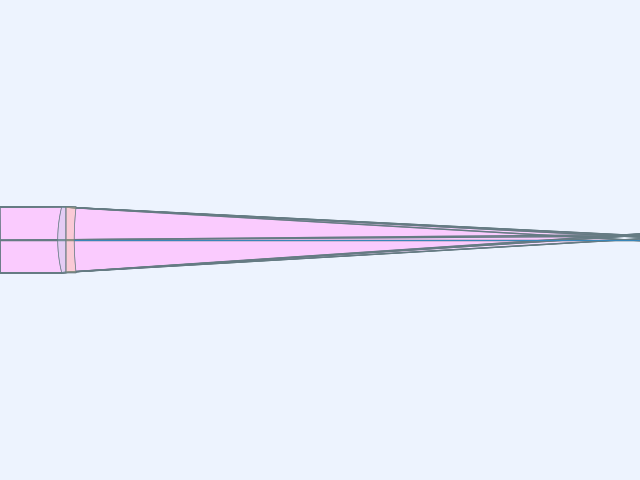

In [5]:
# add a focusing mirror
#sm.add_surface([100, 2, 1.85, 16])
#sm.add_surface([1e9, 36])

opm.update_model()

opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl
opm.update_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()

137.01040075032165

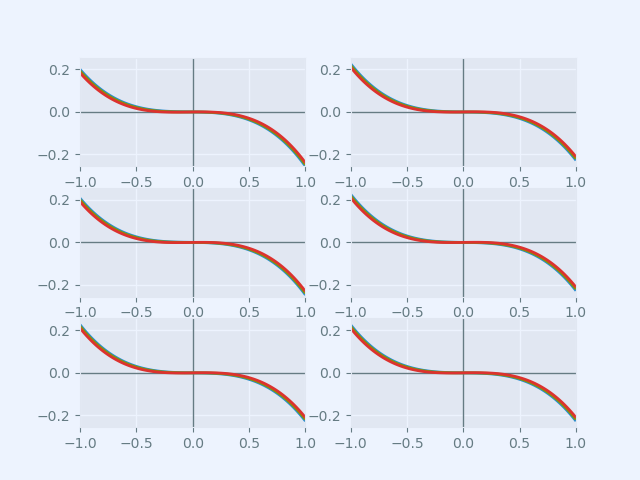

In [6]:
#opm.seq_model.gaps[-1].thi -= 0.1
opm.update_model()
#spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
#                      user_scale_value=0.1, is_dark=isdark).plot()
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray',
                     scale_type=Fit.All_Same).plot()
opm.seq_model.gaps[-1].thi

137.01040075032165

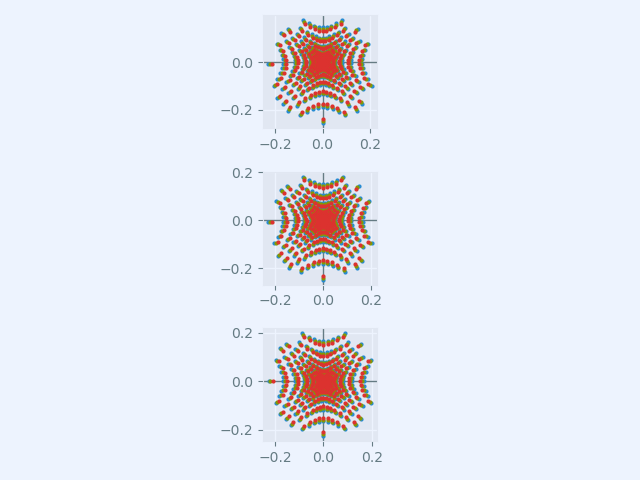

In [7]:
#opm.seq_model.gaps[-1].thi -= 0.1
opm.update_model()
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()

opm.seq_model.gaps[-1].thi

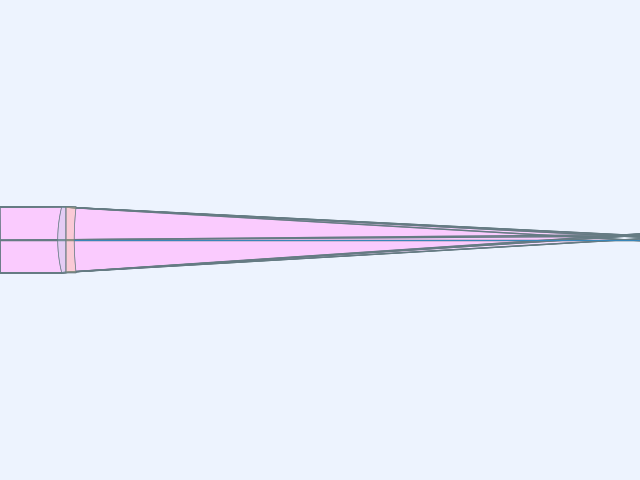

In [8]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()

In [9]:
def dump_pts(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        ray = ray_pkg[0][-1]
        return ray_pkg[0][-1][0]
               
#sm.trace_grid(dump_pts, 0, form='list', append_if_none=False)

In [10]:
def dump_dist(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        image_pt = fld.ref_sphere[0]
        ray = ray_pkg[0]
        dist = foc / ray[-1][1][2]
        defocused_pt = ray[-1][0] + dist*ray[-1][1]
        t_abr = defocused_pt - image_pt
        return np.sqrt(np.sum(t_abr*t_abr))
        
spot_rms = np.sqrt(np.mean(np.square(sm.trace_grid(dump_dist, 0, form='list', append_if_none=False)[0]), axis=1))
print(spot_rms)

[0.11280863 0.10780063 0.10210127]


In [11]:
def spot_rms(sm):
    return np.sqrt(np.mean(np.square(sm.trace_grid(dump_dist, 0, form='list', append_if_none=False)[0]), axis=1))
'''
def calc_focus(opm, sm):
    old_gap = opm.seq_model.gaps[-1].thi
    offsets = np.linspace(-20, 20, 100)
    spots = np.zeros(offsets.shape)
    for i in range(offsets.shape[0]):
        opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl + offsets[i]
        opm.update_model()
        spots[i] = np.sum(spot_rms(sm))
    opm.seq_model.gaps[-1].thi = old_gap
    opm.update_model()
    
    return offsets[np.argmin(spots)]

f = calc_focus(opm, sm)
print(f)
'''

'\ndef calc_focus(opm, sm):\n    old_gap = opm.seq_model.gaps[-1].thi\n    offsets = np.linspace(-20, 20, 100)\n    spots = np.zeros(offsets.shape)\n    for i in range(offsets.shape[0]):\n        opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl + offsets[i]\n        opm.update_model()\n        spots[i] = np.sum(spot_rms(sm))\n    opm.seq_model.gaps[-1].thi = old_gap\n    opm.update_model()\n    \n    return offsets[np.argmin(spots)]\n\nf = calc_focus(opm, sm)\nprint(f)\n'

[0.16672045 0.1716864  0.1773614 ]


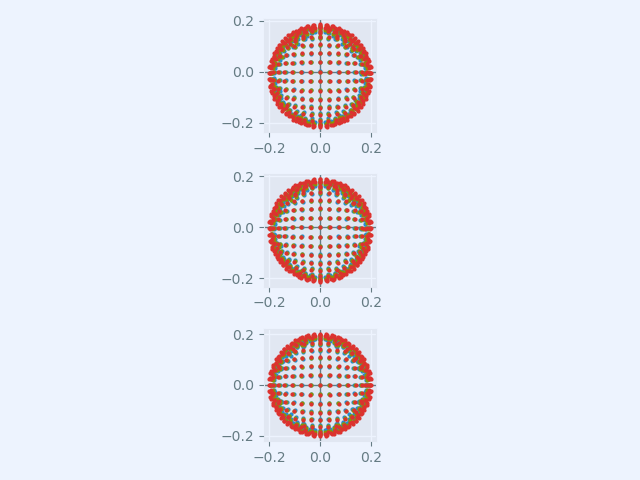

In [12]:
opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl - 6.6666
opm.update_model()

spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()
print(spot_rms(sm))

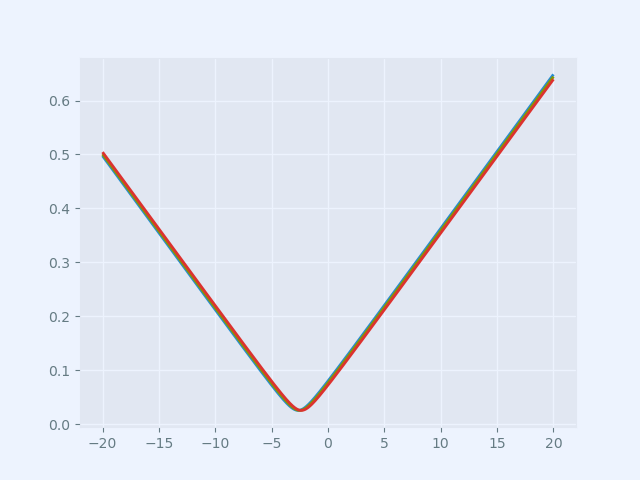

(-2.6626626626626617, -2.5025025025025016, -2.3823823823823815)

In [13]:
import rayoptics.optical.model_constants as mc

old_gap = opm.seq_model.gaps[-1].thi
offsets = np.linspace(-20, 20, 1000)

opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl
opm.update_model()

def dump_rays(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        image_pt = fld.ref_sphere[0]
        ray = ray_pkg[mc.ray]
        v = ray[-1][mc.d][0:2] / ray[-1][mc.d][2]
        return [ray[-1][mc.p][0:2] - image_pt[0:2], v]

vals, colors = sm.trace_grid(dump_rays, 0, form='list', append_if_none=False)
v1, v2, v3 = vals
v1_p = v1[:,0]
v1_v = v1[:,1]
v2_p = v2[:,0]
v2_v = v2[:,1]
v3_p = v3[:,0]
v3_v = v3[:,1]

v1_rms = np.zeros(offsets.size)
v2_rms = np.zeros(offsets.size)
v3_rms = np.zeros(offsets.size)

for i in range(offsets.size):
    v1_rms[i] = np.sqrt(np.mean(np.square(v1_p+v1_v*offsets[i])))
    v2_rms[i] = np.sqrt(np.mean(np.square(v2_p+v2_v*offsets[i])))
    v3_rms[i] = np.sqrt(np.mean(np.square(v3_p+v3_v*offsets[i])))

opm.seq_model.gaps[-1].thi = old_gap
opm.update_model()

plt.figure()
plt.plot(offsets, v1_rms, color=colors[0])
plt.plot(offsets, v2_rms, color=colors[1])
plt.plot(offsets, v3_rms, color=colors[2])
plt.show()

min_b, min_g, min_r = (offsets[np.argmin(v1_rms)], offsets[np.argmin(v2_rms)], offsets[np.argmin(v3_rms)])
min_b, min_g, min_r

[0.03725505 0.03611947 0.03574278]


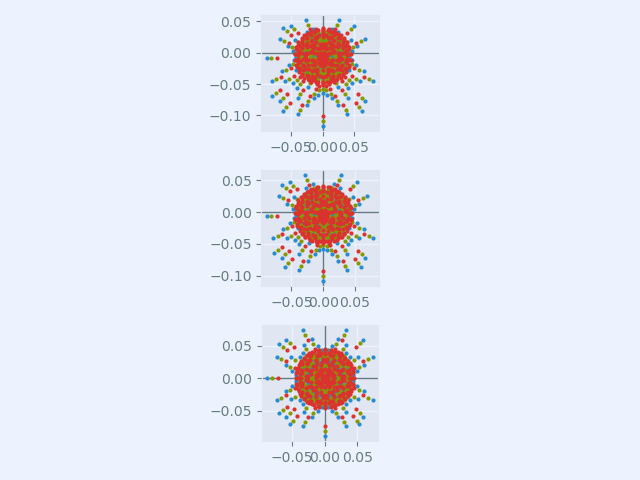

In [14]:
opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl + min_r
opm.update_model()

spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()
print(spot_rms(sm))

[0.03617745 0.03572421 0.03615391]


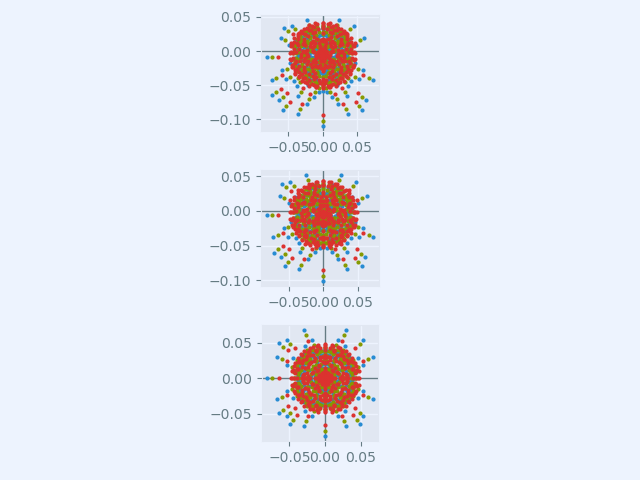

In [15]:
opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl + min_g
opm.update_model()

spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()
print(spot_rms(sm))

[0.03573303 0.03621866 0.03768028]


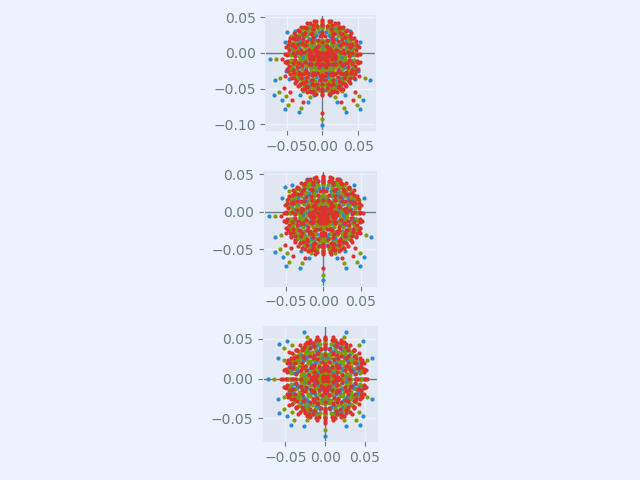

In [16]:
opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl + min_b
opm.update_model()

spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()
print(spot_rms(sm))

[0.03611575 0.03572091 0.03621733]


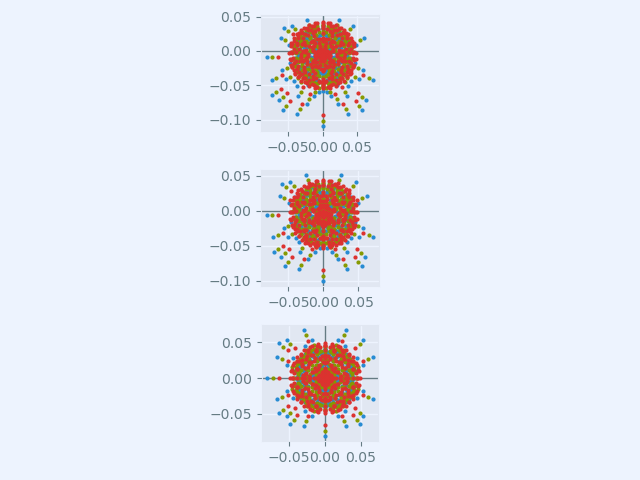

In [17]:
opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl + (min_r*0.25 + min_g*0.5 + min_b*0.25)
opm.update_model()

spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()
print(spot_rms(sm))

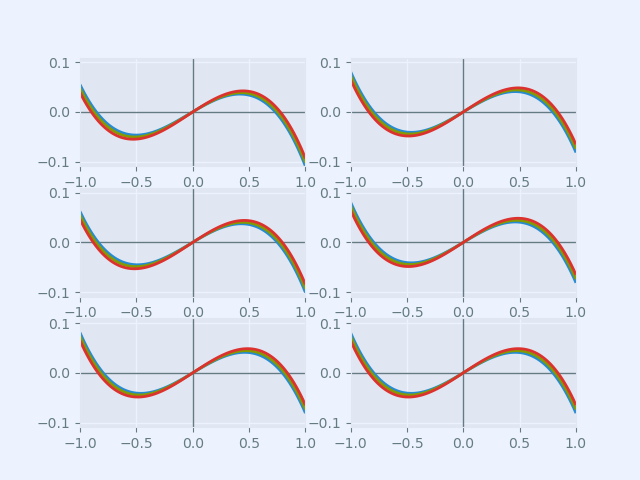

In [18]:
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray',
                     scale_type=Fit.All_Same).plot()